In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import glob  # Can be useful but we use os


In [2]:
SIZE = 256
BATCH_SIZE = 32
CHANNELS = 1  # Grayscale images
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)
GENDER_FEATURE_SHAPE = (1,)  # gender (0 or 1)
EPOCHS = 50
LEARNING_RATE = 4e-4

In [3]:
base_dir = '.'

# Data Paths
train_csv_path = os.path.join(base_dir, 'Train', 'train_labels.csv')
val_csv_path = os.path.join(base_dir, 'Val', 'val_labels.csv')
test_csv_path = os.path.join(base_dir, 'Test', 'test_labels.csv')

train_image_dir = os.path.join(base_dir, 'Train', 'train_samples_pp')
val_image_dir = os.path.join(base_dir, 'Val', 'val_samples_pp')
test_image_dir = os.path.join(base_dir, 'Test', 'test_samples_pp')

checkpoint_filepath = 'Models/gender_model.keras' # tf package says .keras is more efficient


def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')

    df = df[['boneage', 'male']].rename(columns={'male': 'gender'})
    df['gender'] = df['gender'].astype(np.float32)
    df['boneage'] = df['boneage'].astype(np.float32)
    return df


def create_dataframe(image_dir, labels_df):
    data = []

    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            gender = labels_df.loc[file_id, 'gender']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage, 'gender': gender})

    return pd.DataFrame(data)


def preprocess_image(image, labels):
    """preprocesses the image, passes labels through."""
    image = tf.image.resize(image, [SIZE, SIZE])
    # Ensure correct channel dimension if decode_image didn't set it
    if image.shape[-1] is None:
        image = tf.reshape(image, [SIZE, SIZE, CHANNELS])
    elif image.shape[-1] != CHANNELS:

        print(f"Warning: Image has {image.shape[-1]} channels, expected {CHANNELS}. Converting to grayscale.")
        image = tf.image.rgb_to_grayscale(image)  # example if source is RGB

    image = tf.cast(image, tf.float32) / 255.0
    return image, labels  # labels = (boneage, gender)


def image_label_generator(file_paths, boneage_labels, gender_labels):
    """tuple of (boneage, gender) labels."""
    for path, boneage, gender in zip(file_paths, boneage_labels, gender_labels):
        try:
            img_bytes = tf.io.read_file(path)

            image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)

            # allow dynamic height/width initially
            image.set_shape([None, None, CHANNELS])
            yield image, (boneage, gender)  # Yield image and label tuple
        except tf.errors.InvalidArgumentError as e:
            print(f"Warning: Skipping file {path}. Error decoding image: {e}")
        except Exception as e:
            print(f"Warning: Skipping file {path}. Unexpected error: {e}")


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):

    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[
            dataframe['file_path'].values,
            dataframe['boneage'].values,
            dataframe['gender'].values],
        output_signature=(
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            (tf.TensorSpec(shape=(), dtype=tf.float32), tf.TensorSpec(shape=(), dtype=tf.float32))))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)    # preprocessing

    # Keras multi-input model:
    # map (image, (boneage, gender)) to ((image, gender), boneage)
    dataset = dataset.map(lambda img, labels: ((img, labels[1]), labels[0]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


# labels
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

# df
training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)


# repeat=True for train/validation
train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=True)
# repeat=False for final evaluation on test set
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)


In [4]:
def gender_model(input_shape, gender_shape):

    # inputs
    image_input = keras.Input(shape=input_shape, name="image_input")
    gender_input = keras.Input(shape=gender_shape, name="gender_input")

    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1a')(image_input)
    x = layers.BatchNormalization(name='bn1a')(x)
    x = layers.Activation('relu', name='relu1a')(x)
    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1b')(x)
    x = layers.BatchNormalization(name='bn1b')(x)
    x = layers.Activation('relu', name='relu1b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)  # 500 -> 250

    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2a')(x)
    x = layers.BatchNormalization(name='bn2a')(x)
    x = layers.Activation('relu', name='relu2a')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2b')(x)
    x = layers.BatchNormalization(name='bn2b')(x)
    x = layers.Activation('relu', name='relu2b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)  # 250 -> 125

    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3a')(x)
    x = layers.BatchNormalization(name='bn3a')(x)
    x = layers.Activation('relu', name='relu3a')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3b')(x)
    x = layers.BatchNormalization(name='bn3b')(x)
    x = layers.Activation('relu', name='relu3b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool3')(x)  # 125 -> 62

    x = layers.Conv2D(256, (3, 3), padding='same', name='conv4a')(x)
    x = layers.BatchNormalization(name='bn4a')(x)
    x = layers.Activation('relu', name='relu4a')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', name='conv4b')(x)
    x = layers.BatchNormalization(name='bn4b')(x)
    x = layers.Activation('relu', name='relu4b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool4')(x)  # 62 -> 31

    x = layers.Conv2D(256, (3, 3), padding='same', name='conv5a')(x)
    x = layers.BatchNormalization(name='bn5a')(x)
    x = layers.Activation('relu', name='relu5a')(x)
    x = layers.Conv2D(256, (3, 3), padding='same', name='conv5b')(x)
    x = layers.BatchNormalization(name='bn5b')(x)
    x = layers.Activation('relu', name='relu5b')(x)
    x = layers.MaxPooling2D((2, 2), name='pool5')(x)  # 31 -> 15 (approx)

    # feature extraction
    image_features = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)  # (None, 256)

    # fusion with gender
    concatenated_features = layers.concatenate([image_features, gender_input],
                                               name='concatenate_features')  # (None, 257)

    # regression head
    x = layers.Dense(128, name='dense_head1')(concatenated_features)
    x = layers.BatchNormalization(name='bn_head1')(x)
    x = layers.Activation('relu', name='relu_head1')(x)
    x = layers.Dropout(0.4, name='dropout_head')(x)  # Regularization

    bone_age_output = layers.Dense(1, activation='linear', name='bone_age_output')(x)

    model = keras.Model(
        inputs=[image_input, gender_input],
        outputs=bone_age_output,
        name="bone_age_predictor")

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])  # months

    return model

model = gender_model(INPUT_SHAPE, GENDER_FEATURE_SHAPE)


In [5]:
model.summary()

Model: "bone_age_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1a (Conv2D)     │ (None, 256, 256,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1a                │ (None, 256, 256,  │        128 │ conv1a[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1a (Activation) │ (None, 256, 256,  │          0 │ bn1a[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1b (Conv2D)     │ (None, 256, 256,  │      9,248 │ relu1a[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1b                │ (None, 256, 256,  │        128 │ conv1b[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1b (Activation) │ (None, 256, 256,  │          0 │ bn1b[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 128, 128,  │          0 │ relu1b[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2a (Conv2D)     │ (None, 128, 128,  │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a                │ (None, 128, 128,  │        256 │ conv2a[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2a (Activation) │ (None, 128, 128,  │          0 │ bn2a[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2b (Conv2D)     │ (None, 128, 128,  │     36,928 │ relu2a[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2b                │ (None, 128, 128,  │        256 │ conv2b[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu2b (Activation) │ (None, 128, 128,  │          0 │ bn2b[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 64, 64,    │          0 │ relu2b[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3a (Conv2D)     │ (None, 64, 64,    │     73,856 │ pool2[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3a                │ (None, 64, 64,    │        512 │ conv3a[0][0]    

 Total params: 2,391,393 (9.12 MB)

 Trainable params: 2,388,193 (9.11 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [6]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mae', # save the best mae
    mode='min',
    save_best_only=True)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    mode='min',
    restore_best_weights=True)
# restore best weights because it tends to overfit
# monitor loss because it's the actual improvement metric meanwhile mae can be a face value metric

reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    mode='min',
    min_lr=1e-6)
# trial and error came to a best hyperparam of 3 epochs

callback_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]

Training wt train/val/test split

In [7]:
steps = len(training_dataframe) // BATCH_SIZE
val_steps = len(validation_dataframe) // BATCH_SIZE

history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=steps,
        validation_data=validation_dataset,
        validation_steps=val_steps,
        callbacks=callback_list,
        verbose=1)

Epoch 1/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1025s 3s/step - loss: 16838.7188 - mae: 123.1551 - val_loss: 15304.8438 - val_mae: 116.3782 - learning_rate: 4.0000e-04
Epoch 2/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 992s 3s/step - loss: 13469.7783 - mae: 109.7373 - val_loss: 9950.9746 - val_mae: 93.3047 - learning_rate: 4.0000e-04
Epoch 3/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - loss: 9133.8174 - mae: 89.3867 - val_loss: 2497.8997 - val_mae: 43.0969 - learning_rate: 4.0000e-04
Epoch 4/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - loss: 4743.0249 - mae: 62.9347 - val_loss: 2853.0376 - val_mae: 47.1767 - learning_rate: 4.0000e-04
Epoch 5/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 1013s 3s/step - loss: 1885.9617 - mae: 37.7186 - val_loss: 861.7642 - val_mae: 23.3435 - learning_rate: 4.0000e-04
Epoch 6/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 992s 3s/step - loss: 746.8690 - mae: 22.0391 - val_loss: 610.1957 - val_mae: 20.3794 - learning_rate: 4.0000e-04
Epoch 7/50
376/376 ━━━━━━━━━━━━━━━━━━━━ 998s 3s/step - loss: 482.

In [4]:
best_model = keras.models.load_model(checkpoint_filepath)

test_results = best_model.evaluate(test_dataset_eval, verbose=1, steps=1)  # gives problems with more than 1 step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 57.1912 - mae: 6.0217


In [5]:
test_results

[57.19122314453125, 6.021697044372559]

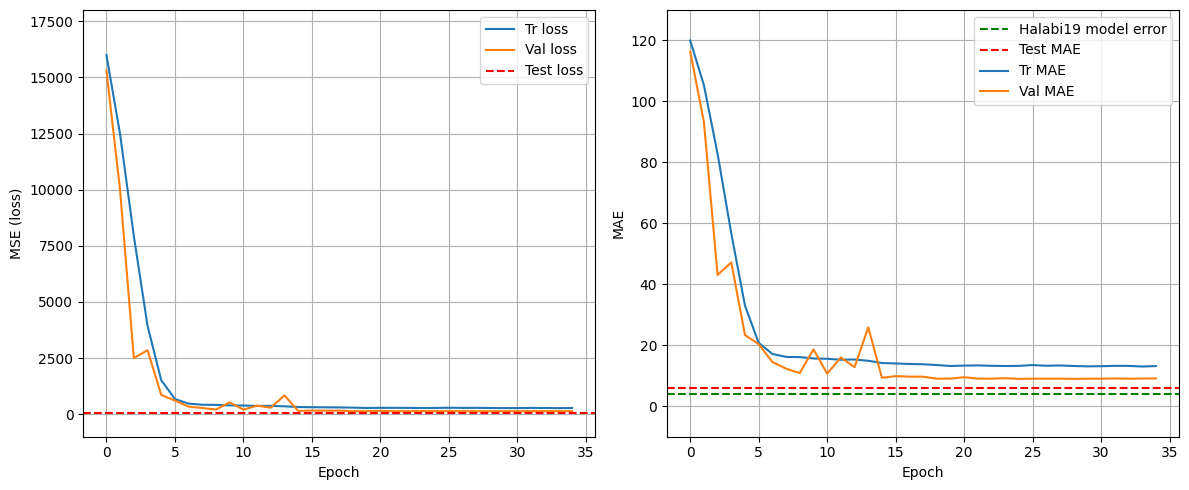

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.ylim(-1000, 18000)
plt.plot(history.history['loss'], label='Tr loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.axhline(y=test_results[0], color='r', linestyle='--', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.ylim(-10, 130)
plt.axhline(y=4, color='g', linestyle='--', label='Halabi19 model error')
plt.axhline(y=test_results[1], color='r', linestyle='--', label='Test MAE')
plt.plot(history.history['mae'], label='Tr MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


Text(0, 0.5, 'lr')

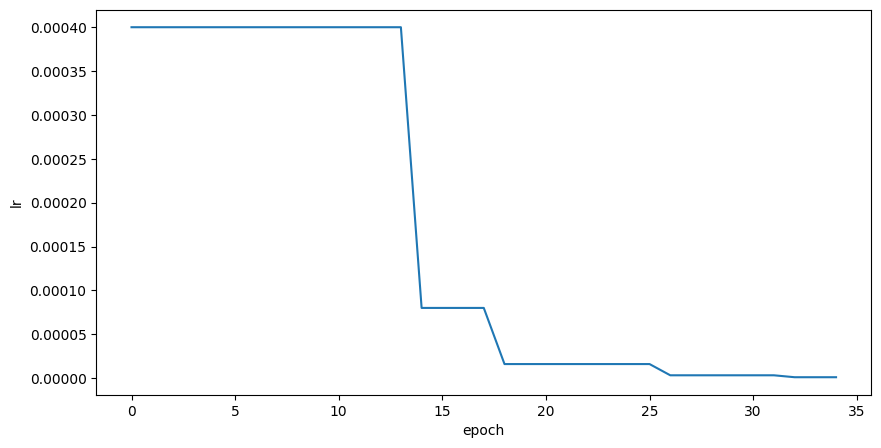

In [56]:

lrs = [4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04,
    4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04,
    4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04, 8.0000e-05,
    8.0000e-05, 8.0000e-05, 8.0000e-05, 1.6000e-05, 1.6000e-05,
    1.6000e-05, 1.6000e-05, 1.6000e-05, 1.6000e-05, 1.6000e-05,
    1.6000e-05, 3.2000e-06, 3.2000e-06, 3.2000e-06, 3.2000e-06,
    3.2000e-06, 3.2000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06]

plt.figure(figsize=(10, 5))
plt.plot(lrs)
plt.xlabel('epoch')
plt.ylabel('lr')   # stopped at 35 epochs

In [71]:
preds = best_model.predict(test_dataset_eval, steps=5)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step


In [72]:
P = []

for i in preds:
    P.append(i[0])

Y = test_dataframe['boneage'].tolist()

In [73]:
res = np.array(P) - np.array(Y)

In [74]:
res

array([ -1.14537048,  -5.12896729,   6.6864624 ,  -6.84107208,
         8.20570374,  10.93682861,  -2.11361694, -16.71630096,
        -6.08827209,  -3.2414856 ,  -4.64408875,  -1.48800659,
        -8.37973022,  21.18453979,   1.83857727,  -5.56881332,
        -1.86514282,  -0.97909546,  -3.22572327,   3.61486053,
        -0.04301453,  13.8671627 ,   7.24945736,  -3.24330139,
         5.17234039,   9.08763123,   4.60086823,   5.36601257,
         2.44554138,   4.90809631,  -9.2182312 ,  -7.59997559,
         1.03439331,  12.09436035, -13.41662598, -17.29347992,
        16.42169189,  -9.04624939,   0.58738708,   5.18234253,
         7.56365967,  -6.68771362,   0.97811127,  -3.4813385 ,
         4.05485535,  15.53756714,   1.56262207,   7.08215332,
       -13.19398499,  -3.32028198,  -3.88621521,  -2.45122528,
        29.93726349, -15.23548889,  -3.4375    ,  14.32298279,
        -2.33816528,  10.68982697,   5.69259644,  12.48322296,
        -2.39868164,  -0.13743591,  -7.60132217, -14.52

In [ ]:
P = np.array(P)
Y = np.array(Y)

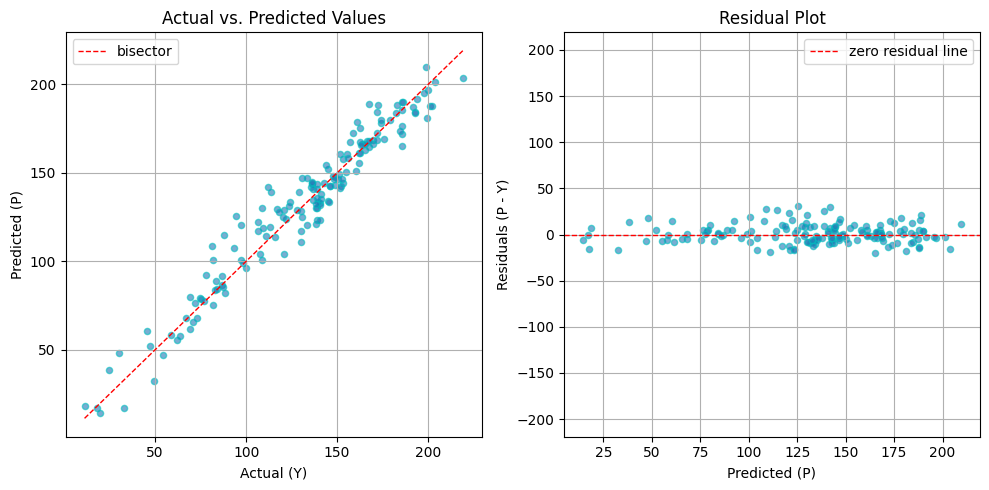

In [93]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(Y, P, alpha=0.6, edgecolors='c', s=20)
min_val = min(np.min(Y), np.min(P))
max_val = max(np.max(Y), np.max(P))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1, label='bisector')
plt.xlabel("Actual (Y)")
plt.ylabel("Predicted (P)")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.ylim(-max(Y), max(Y))
plt.scatter(P, res, alpha=0.6, edgecolors='c', s=20)
plt.axhline(0, color='r', linestyle='--', lw=1, label='zero residual line')
plt.xlabel("Predicted (P)")
plt.ylabel("Residuals (P - Y)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()